<a href="https://colab.research.google.com/github/mateuslatrova/correcao-enem/blob/main/cluster_of_words_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# requirements on Google Colab:
!pip install scipy scikit-learn datasets evaluate transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.1 MB/s eta 0:00:00


In [2]:
import os
import random
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/MyDrive/")
os.getcwd()

'/content/drive/MyDrive'

In [ ]:
! git clone https://github.com/mateuslatrova/correcao-enem.git

fatal: destination path 'correcao-enem' already exists and is not an empty directory.


In [4]:
os.chdir("/content/drive/MyDrive/correcao-enem")
os.getcwd()

'/content/drive/MyDrive/correcao-enem'

In [ ]:
! git pull

Already up to date.


In [5]:
from datasets import (
    concatenate_datasets,
    Dataset,
    DatasetDict,
    load_dataset,
    load_from_disk,
)
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from transformers import (
    AdamW,
    AutoTokenizer,
    AutoModelForPreTraining,
    AutoModel,
    AutoModelForSequenceClassification,
    BertLMHeadModel,
    BertTokenizer,
    GPT2Tokenizer, GPT2LMHeadModel,
    DataCollatorWithPadding,
    get_scheduler,
    Trainer,
    TrainingArguments,
)


In [6]:
checkpoint = "neuralmind/bert-base-portuguese-cased"

raw_files_dirpath = os.path.abspath("data/raw")
preprocessed_files_dirpath = os.path.abspath("data/preprocessed/")
processed_files_dirpath = os.path.abspath("data/processed/")

raw_files_extension = ".csv"

raw_essay_filename = "redacoes"
raw_topic_filename = "temas"

preprocessed_essay_filename = "redacoes_fuga_do_tema"
preprocessed_topic_filename = "temas_fuga_do_tema"

topic_deviation_dataset_filename = "fuga_do_tema"

raw_essay_dataset_filepath = os.path.join(
    raw_files_dirpath, raw_essay_filename + raw_files_extension
)
raw_topic_dataset_filepath = os.path.join(
    raw_files_dirpath, raw_topic_filename + raw_files_extension
)
preprocessed_essay_dataset_filepath = os.path.join(
    preprocessed_files_dirpath, preprocessed_essay_filename
)
preprocessed_topic_dataset_filepath = os.path.join(
    preprocessed_files_dirpath, preprocessed_topic_filename
)

processed_dataset_filepath = os.path.join(processed_files_dirpath, topic_deviation_dataset_filename)

In [7]:
class EssayDatasetPreprocessorForClusterOfWords:
    COLUMNS_TO_REMOVE = [
        "title",
        "final_grade",
        "is_ENEM",
        "is_convertible",
        "general",
        "specific",
        "grades",
    ]
    RENAME_COLUMNS_MAP = {
        "id": "essay_id",
        "id_prompt": "topic_id",
        "essay": "essay_text",
    }
    SECOND_GRADE_INDEX = 1
    GRADE_THRESHOLD = 0
    TEST_DATASET_SIZE = 0.15
    ESSAY_ID_COLUMN = "essay_id"

    def __init__(self, dataset: Dataset):
        self.original_dataset = dataset

    def preprocess_dataset(self) -> DatasetDict:
        self.train_dataset = (
            self.original_dataset.rename_columns(self.RENAME_COLUMNS_MAP)
            .map(self._preprocess_essay)
            .map(self._create_column_for_second_grade)
        )

        self.train_dataset = self.train_dataset.remove_columns(self.COLUMNS_TO_REMOVE)

        self.dataset_dict = DatasetDict({"train": self.train_dataset})

        return self.dataset_dict

    def _preprocess_essay(self, example):
        essay_before = example["essay_text"]
        essay_after = ""

        paragraphs = eval(essay_before)
        for paragraph in paragraphs:
            essay_after += paragraph

        example["essay_text"] = essay_after
        return example

    def _create_column_for_second_grade(self, example):
        grades_list = eval(example["grades"])
        second_grade = grades_list[self.SECOND_GRADE_INDEX]
        example["second_grade"] = second_grade
        return example

In [8]:
dataset_dict = load_dataset("csv", data_files=raw_essay_dataset_filepath)
train_dataset = dataset_dict["train"]
dataset_dict

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'id_prompt', 'title', 'essay', 'grades', 'final_grade', 'is_ENEM', 'is_convertible', 'general', 'specific'],
        num_rows: 385
    })
})

In [9]:
train_dataset = dataset_dict["train"]
train_dataset

Dataset({
    features: ['id', 'id_prompt', 'title', 'essay', 'grades', 'final_grade', 'is_ENEM', 'is_convertible', 'general', 'specific'],
    num_rows: 385
})

In [10]:
preprocessor = EssayDatasetPreprocessorForClusterOfWords(train_dataset)
preprocessed_dataset_dict = preprocessor.preprocess_dataset()
preprocessed_dataset_dict

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'topic_id', 'essay_text', 'second_grade'],
        num_rows: 385
    })
})

In [11]:
dataset_dict = preprocessed_dataset_dict

In [12]:
device = "cuda"

In [13]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = BertLMHeadModel.from_pretrained(checkpoint, is_decoder=True).to(device)

In [14]:
def tokenize(example):
    return tokenizer(
        example["essay_text"],
        truncation=True,
        padding=True,
        max_length=512,
        add_special_tokens=True,
        return_tensors="pt",
    )

tokenized_datasets = dataset_dict.map(tokenize, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(
    ["essay_id",  "topic_id", "second_grade", "essay_text"]
)
tokenized_datasets

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 385
    })
})

In [26]:
def calculate_text_perplexity(text):
  input_ids = tokenizer.encode(text, return_tensors="pt", max_length=512).to(device)

  with torch.no_grad():
      outputs = model(input_ids, labels=input_ids)
      log_likelihood = outputs.loss.item()

  perplexity = np.exp(-log_likelihood)

  return perplexity

In [46]:
dataset = dataset_dict["train"]
dataset.set_format("pandas")
df = dataset[:]
df

,essay_id,topic_id,essay_text,second_grade
0,0,0,Com os avanços que a sociedade deu em tecnolog...,200
1,1,0,"De acordo com pesquisas, o Brasil é o país da ...",120
2,2,0,Em uma pesquisa recente realizada pela ONG Oxf...,80
3,3,0,"A ideia de vencer na vida, presente no imaginá...",200
4,4,0,O caminho do sucessoÉ de fundamental importânc...,80
...,...,...,...,...
380,809,43,"A descoberta do fogo pelo homem, ocasionou a R...",80
381,810,43,Em contraponto às conquistas do Renascimento C...,120
382,811,43,Rene Descartes e Galileu Galilei são duas figu...,120
383,812,43,É notório o aumento da discussão acerca da inf...,120


In [16]:
# posso quebrar as redações em chunks de 100 caracteres, criando assim, varias linhas no dataset
# para cada redação.
# entao, podemos passar cada um desses chunks pelo calculo da perplexidade, e a perplexidade
# da redacao será a média das perplexidades dos seus chunks.
import textwrap

def split_text_into_chunks(text, chunk_size):
    return textwrap.wrap(text, chunk_size)

In [21]:
new_rows = []
chunk_size = 512

In [22]:
for index, row in df.iterrows():
    text_id = row['essay_id']
    text = row['essay_text']

    chunks = split_text_into_chunks(text, chunk_size)

    for chunk in chunks:
        new_row = {'essay_id': text_id, 'essay_text': chunk, 'second_grade': row["second_grade"]}
        new_rows.append(new_row)

In [23]:
new_df = pd.DataFrame(new_rows)
new_df

,essay_id,essay_text,second_grade
0,0,Com os avanços que a sociedade deu em tecnolog...,200
1,0,"modernos, como os de ressonância magnética, au...",200
2,0,o maior número de conhecimento possível na áre...,200
3,0,alcançar os sonhos e planos traçados para a vida.,200
4,1,"De acordo com pesquisas, o Brasil é o país da ...",120
...,...,...,...
1435,812,importante destacar o papel das redes sociais ...,120
1436,812,"pública, definindo a partir de evidências e co...",120
1437,813,Atualmente a ciência já desmitificou vários fa...,0
1438,813,entretanto era no período que existia tantos r...,0


In [24]:
new_df = new_df.sort_values(by=["second_grade", "essay_id"]).reset_index(drop=True)
new_df

,essay_id,essay_text,second_grade
0,22,O nosso país está vivenciando diversos acontec...,0
1,22,"homofobia, declarou que os negros não merecem ...",0
2,22,"queremos que nos próximos anos, o Brasil estej...",0
3,27,O Brasil já conseguiu dar um passo para renova...,0
4,27,decorrência desse fenômeno Brasileiro o país t...,0
...,...,...,...
1435,808,"A ciência contribuiu, ao longo dos séculos, pa...",200
1436,808,"caracterizadas por apresentarem inverdades, mu...",200
1437,808,"a população, sendo um claro exemplo desta rela...",200
1438,808,"ciência. Neste processo, as instituições educa...",200


In [47]:
perplexities = []
progress_bar = tqdm(range(len(df.index)))

for essay in df["essay_text"].tolist():
    p = calculate_text_perplexity(essay)
    perplexities.append(p)
    progress_bar.update(1)

df["perplexity"] = perplexities
df = df.sort_values(by=["second_grade", "perplexity"]).reset_index(drop=True)
df

  0%|          | 0/385 [00:00<?, ?it/s]

,essay_id,topic_id,essay_text,second_grade,perplexity
0,206,12,É notório que os direitos em conflitos devem s...,0,1.499978e-08
1,674,37,O supremo tribunal federal é definido como um ...,0,3.894709e-08
2,317,17,A escravidão é algo que não está destacado na ...,0,4.650690e-08
3,282,16,Atualmente é muito discutido um problema na qu...,0,7.448215e-08
4,683,37,De acordo com pesquisas o supremo tribunal fed...,0,8.050814e-08
...,...,...,...,...,...
380,157,9,"Desde a pré-história, o homem sempre se utiliz...",200,3.512533e-07
381,260,15,Os hábitos alimentares são culturais e represe...,200,3.784702e-07
382,586,32,"Com apenas 20 anos de idade, o poeta romântico...",200,4.317771e-07
383,150,9,A humanidade está fadada a superar seus limite...,200,6.687188e-07


In [42]:
mean_df = new_df[["essay_id", "perplexity"]].groupby("essay_id").mean().reset_index()
sum_df = new_df[["essay_id", "perplexity"]].groupby("essay_id").sum().reset_index()

In [43]:
mean_df = mean_df.join(df.set_index("essay_id"), on="essay_id").drop(columns=["topic_id"]).sort_values(by=["second_grade", "perplexity"]).reset_index(drop=True)
sum_df = sum_df.join(df.set_index("essay_id"), on="essay_id").drop(columns=["topic_id"]).sort_values(by=["second_grade", "perplexity"]).reset_index(drop=True)

In [34]:
def plot_experiment_results(df):
    possible_grades = df["second_grade"].unique().tolist()
    last_ocurrence_of_each_grade = []

    for grade in possible_grades:
        last_ocurrence_of_this_grade_index = df[df["second_grade"] == grade].index.tolist()[-1]
        last_ocurrence_of_each_grade.append(last_ocurrence_of_this_grade_index)

    x = df.index
    y = df.perplexity

    # Create a Matplotlib figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot your data
    ax.plot(x, y, label='Perplexity')

    colors = ["red", "green", "purple", "orange", "black", "brown"]
    for i, idx in enumerate(last_ocurrence_of_each_grade):
        ax.axvline(x=idx, color=colors[i], linestyle='--', label=df.loc[idx, "second_grade"])

    # Enable the grid and set its style
    ax.grid(True, linestyle='--', color='gray', alpha=0.6)

    # Add labels and a legend (optional)
    ax.set_xlabel('Count')
    ax.set_ylabel('Perplexity')
    ax.set_title('Perplexity of essays')
    ax.legend()

    # Show the plot
    plt.show()

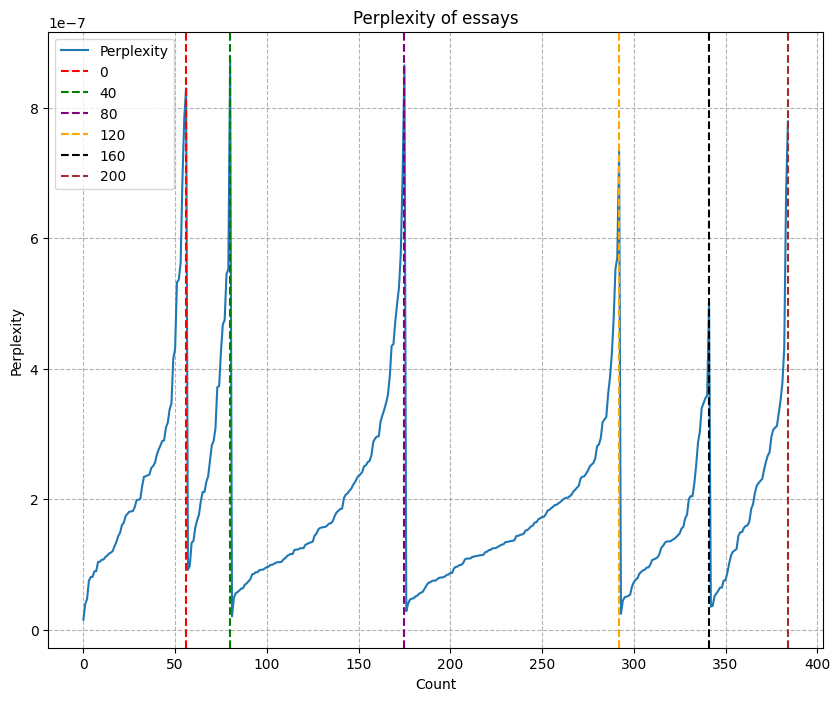

In [48]:
# Passing the raw essay_text
plot_experiment_results(df)

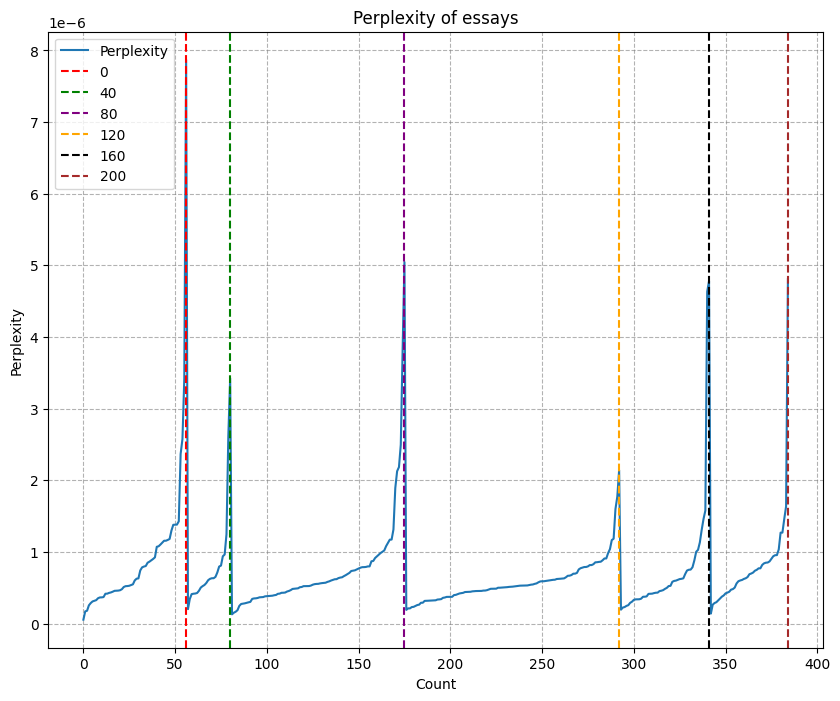

In [44]:
# Breaking each essay in chunks and calculating the perplexity mean of all chunks:
plot_experiment_results(mean_df)

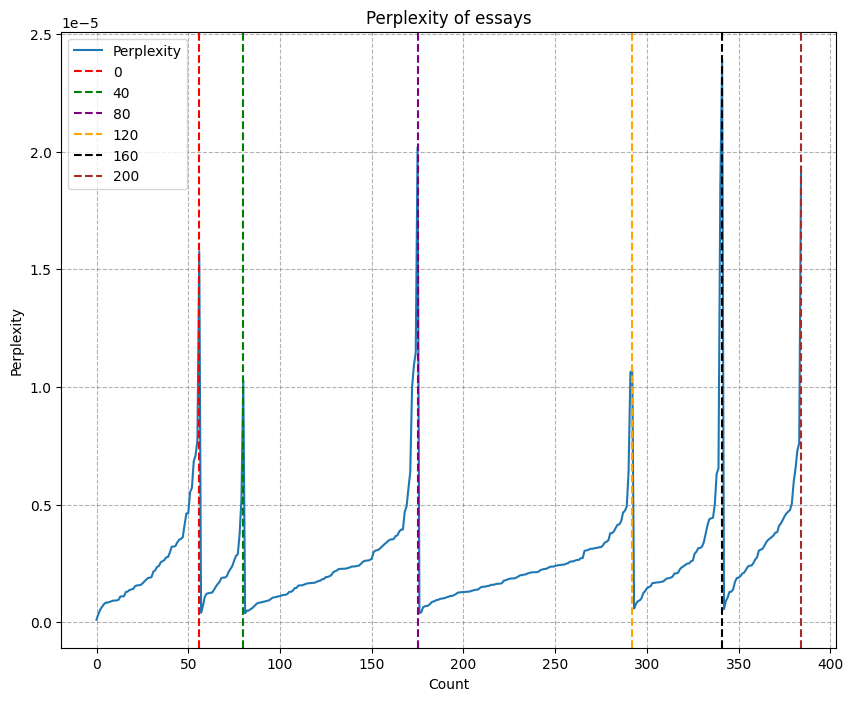

In [45]:
# Breaking each essay in chunks and calculating the perplexity sum of all chunks:
plot_experiment_results(sum_df)

In [56]:
mean_by_grade_df = df[["second_grade", "perplexity"]].groupby("second_grade").mean().reset_index(names="second_grade")
mean_by_grade_df

,second_grade,perplexity
0,0,2.365511e-07
1,40,3.024768e-07
2,80,1.943572e-07
3,120,1.668100e-07
4,160,1.530022e-07
5,200,2.083407e-07


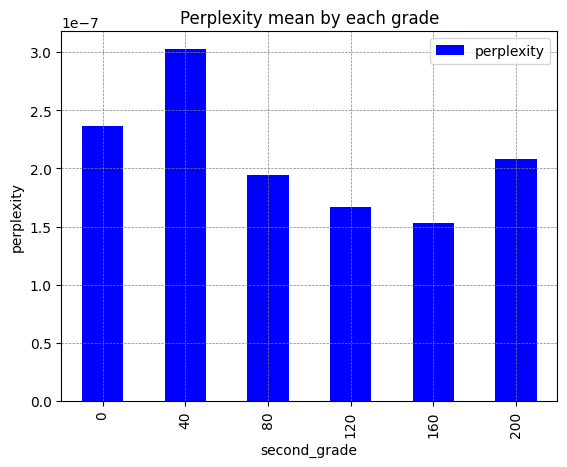

In [66]:
ax = mean_by_grade_df.plot(x="second_grade", y="perplexity", kind="bar", ylabel="perplexity", grid=True, color='blue', title="Perplexity mean by each grade")
ax.yaxis.grid(color='grey', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show()

In [73]:
std_by_grade_df = df[["second_grade", "perplexity"]].groupby("second_grade").std().reset_index(names="second_grade")
std_by_grade_df

,second_grade,perplexity
0,0,1.749264e-07
1,40,1.828192e-07
2,80,1.433923e-07
3,120,1.110600e-07
4,160,9.945392e-08
5,200,1.534291e-07


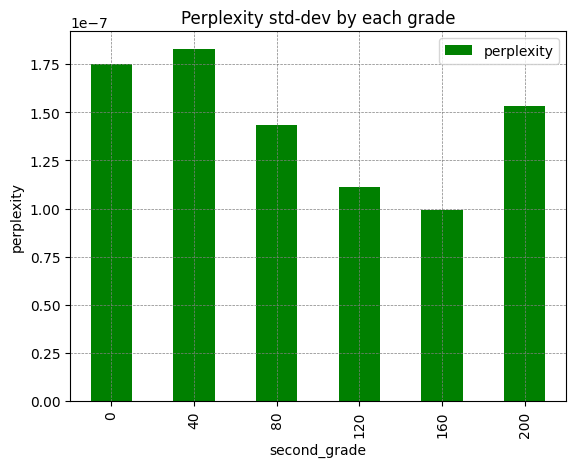

In [74]:
ax = std_by_grade_df.plot(x="second_grade", y="perplexity", kind="bar", ylabel="perplexity", grid=True, color='green', title="Perplexity std-dev by each grade")
ax.yaxis.grid(color='grey', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show()